In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import PIL
from PIL import Image
import cv2

import warnings
from glob import glob

In [2]:
warnings.filterwarnings("ignore")

In [3]:
tf.config.list_physical_devices('GPU')

2022-11-08 08:26:11.630641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 08:26:11.634433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 08:26:11.634992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
pd.set_option('display.max.colwidth', 100)

## Path Setting

In [5]:
base_path = "/data/data/05_DACON/Artist/data"

## Import DATA

In [6]:
train_csv = pd.read_csv(os.path.join(base_path, "train.csv"), encoding='CP949')
test_csv = pd.read_csv(os.path.join(base_path, "test.csv"), encoding='CP949')
submisson = pd.read_csv(os.path.join(base_path, "sample_submission.csv"), encoding='CP949')
art_info = pd.read_csv(os.path.join(base_path, "artists_info.csv"))
df_merge = pd.read_csv(os.path.join(base_path, "df_merge_raw_2_4.csv"))

In [7]:
# 경로 변경
df_merge['img_slice_re_path'] = base_path + '/train_raw_2_4/' + df_merge['img_slice_path'] 

In [8]:
df_merge.head()

,id,img_path,artist,years,genre,nationality,re_img_path,img_slice_path,img_slice_re_path
0,0,./train/0000.jpg,Diego Velazquez,1599 - 1660,Baroque,Spanish,/data/data/05_DACON/Artist/data/train/0000.jpg,0000.jpg,/data/data/05_DACON/Artist/data/train_raw_2_4/0000.jpg
1,0,./train/0000.jpg,Diego Velazquez,1599 - 1660,Baroque,Spanish,/data/data/05_DACON/Artist/data/train/0000.jpg,0000_slice2_01_01.jpg,/data/data/05_DACON/Artist/data/train_raw_2_4/0000_slice2_01_01.jpg
2,0,./train/0000.jpg,Diego Velazquez,1599 - 1660,Baroque,Spanish,/data/data/05_DACON/Artist/data/train/0000.jpg,0000_slice2_01_02.jpg,/data/data/05_DACON/Artist/data/train_raw_2_4/0000_slice2_01_02.jpg
3,0,./train/0000.jpg,Diego Velazquez,1599 - 1660,Baroque,Spanish,/data/data/05_DACON/Artist/data/train/0000.jpg,0000_slice_01_01.jpg,/data/data/05_DACON/Artist/data/train_raw_2_4/0000_slice_01_01.jpg
4,0,./train/0000.jpg,Diego Velazquez,1599 - 1660,Baroque,Spanish,/data/data/05_DACON/Artist/data/train/0000.jpg,0000_slice_01_02.jpg,/data/data/05_DACON/Artist/data/train_raw_2_4/0000_slice_01_02.jpg


In [9]:
print("train artist count : ", len(df_merge['artist'].value_counts()))

train artist count :  50


In [10]:
# 경로 변경
test_csv['re_img_path'] =  [ x.replace('./test/', base_path+'/test/') for x in test_csv['img_path'] ] 

In [11]:
test_csv.head()

,id,img_path,re_img_path
0,TEST_00000,./test/TEST_00000.jpg,/data/data/05_DACON/Artist/data/test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg,/data/data/05_DACON/Artist/data/test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg,/data/data/05_DACON/Artist/data/test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg,/data/data/05_DACON/Artist/data/test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg,/data/data/05_DACON/Artist/data/test/TEST_00004.jpg


## EDA

## 시각화

In [12]:
# def show_grid_images(image_path_list, ncols=6):
#     figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
#     for i in range(ncols):
#       image = cv2.cvtColor(cv2.imread(image_path_list[i]), cv2.COLOR_BGR2RGB)
#       axs[i].set_title(image_path_list[i][-8:])
#       axs[i].imshow(image)

In [13]:
# artist별 image
# artist_list = list(df_merge['artist'].value_counts().index)
# for art in artist_list :
#   show_grid_images(df_merge[df_merge["artist"] == art ]["re_img_path"].values[:6])
#   print(art)

In [14]:
# genre별 image
# genre_list = list(df_merge['genre'].value_counts().index)
# for genre in genre_list :
#   show_grid_images(df_merge[df_merge["genre"] == genre ]["re_img_path"].values[:6])
#   print(genre)

In [15]:
# nationality별 image
# nationality_list = list(df_merge['nationality'].value_counts().index)
# for nat in nationality_list :
#   show_grid_images(df_merge[df_merge["nationality"] == nat ]["re_img_path"].values[:6])
#   print(nat)

## Hyperparameter Setting

In [13]:
CFG = {
    'IMG_SIZE':300,
    'EPOCHS':50,
    'LEARNING_RATE':5e-4,
    'BATCH_SIZE':32,
    'SEED':42,
    'VALIDATION_SPLIT' : 0.1
}

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(
    #rescale=1./255,
    validation_split=CFG['VALIDATION_SPLIT'],
    zoom_range = [0.5,1],
#     horizontal_flip=True,
#     vertical_flip=True,    
)

In [15]:
train_gen = datagen.flow_from_dataframe(df_merge, x_col='img_slice_re_path', y_col='artist', target_size=(CFG['IMG_SIZE'],CFG['IMG_SIZE']), batch_size=CFG['BATCH_SIZE'], seed=CFG['SEED'])
train_gen.class_indices

Found 41377 validated image filenames belonging to 50 classes.


{'Albrecht Du rer': 0,
 'Alfred Sisley': 1,
 'Amedeo Modigliani': 2,
 'Andrei Rublev': 3,
 'Andy Warhol': 4,
 'Camille Pissarro': 5,
 'Caravaggio': 6,
 'Claude Monet': 7,
 'Diego Rivera': 8,
 'Diego Velazquez': 9,
 'Edgar Degas': 10,
 'Edouard Manet': 11,
 'Edvard Munch': 12,
 'El Greco': 13,
 'Eugene Delacroix': 14,
 'Francisco Goya': 15,
 'Frida Kahlo': 16,
 'Georges Seurat': 17,
 'Giotto di Bondone': 18,
 'Gustav Klimt': 19,
 'Gustave Courbet': 20,
 'Henri Matisse': 21,
 'Henri Rousseau': 22,
 'Henri de Toulouse-Lautrec': 23,
 'Hieronymus Bosch': 24,
 'Jackson Pollock': 25,
 'Jan van Eyck': 26,
 'Joan Miro': 27,
 'Kazimir Malevich': 28,
 'Leonardo da Vinci': 29,
 'Marc Chagall': 30,
 'Michelangelo': 31,
 'Mikhail Vrubel': 32,
 'Pablo Picasso': 33,
 'Paul Cezanne': 34,
 'Paul Gauguin': 35,
 'Paul Klee': 36,
 'Peter Paul Rubens': 37,
 'Pierre-Auguste Renoir': 38,
 'Piet Mondrian': 39,
 'Pieter Bruegel': 40,
 'Raphael': 41,
 'Rembrandt': 42,
 'Rene Magritte': 43,
 'Salvador Dali': 44,


In [16]:
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve
from keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

## Modeling(ensemble)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
import albumentations as al

In [21]:
kf = KFold(n_splits=3, shuffle=True,random_state=CFG['SEED']) # 3 Fold Validation

def EfficientNetB3_model():

    for fold_var, (train_index, valid_index) in enumerate(kf.split(df_merge, df_merge['artist']), 1) :

        x_train = df_merge.iloc[train_index]
        x_valid = df_merge.iloc[valid_index]
        train_gen = datagen.flow_from_dataframe(x_train, x_col='img_slice_re_path', y_col='artist', target_size=(CFG['IMG_SIZE'],CFG['IMG_SIZE']), batch_size=CFG['BATCH_SIZE'], seed=CFG['SEED'])
        valid_gen = datagen.flow_from_dataframe(x_valid, x_col='img_slice_re_path', y_col='artist', target_size=(CFG['IMG_SIZE'],CFG['IMG_SIZE']), batch_size=CFG['BATCH_SIZE'], seed=CFG['SEED']) 
        # 대부분은 vaildset에 augment를 적용하지 않지만, 대부분의 이미지들이 이미 rotate, filp등이 적용된 상태였고, ReduceLROnPlateau로 적절한 시점에서의 lr 조정을 위해 실험해본 결과 지금과 같이 단순한 90도 rotation 적용은 최종 정확도에 약간의 긍정적인 영향을 주었기에 이를 적용하였습니다.
        # 최종 평가 학습 부분에서는 90도 회전이 아닌 -90도~90도까지의 다양한 각도 회전 augmentation을 적용하였기에 분명히 augmentation을 적용하지 않았어야 했는데 이 부분을 수정하지 않아 문제가 되었습니다
        tf.random.set_seed(CFG['SEED'])
        input_tensor = Input(shape=(CFG['IMG_SIZE'], CFG['IMG_SIZE'], 3))  

        base_model = EfficientNetB3(input_tensor=input_tensor, include_top=False, weights='imagenet')
        base_model.trainable = True # 재학습 여부
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
#         x = Dense(512, activation='relu')(x)
#         x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        output = Dense(50, activation='softmax')(x)
        model = Model(inputs=input_tensor, outputs=output)

        model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = [f1score, 'acc']) # Adam lr = 0.001(default)
        es = EarlyStopping(patience=10, restore_best_weights=True, verbose=1) 
        rl = ReduceLROnPlateau(patience=5, verbose=1, factor=0.5, min_lr=1e-5) 
        cb = ModelCheckpoint(filepath=base_path + '/fold{}_EfficientNetB3_raw_2_4_best_221107.h5'.format(str(fold_var)), save_best_only=True, exist_ok=True, verbose=1)
        model.fit(train_gen, validation_data=valid_gen, epochs=CFG['EPOCHS'], callbacks=[es,cb,rl]) 

    K.clear_session()
    
    return model

In [22]:
model = EfficientNetB3_model()

Found 27584 validated image filenames belonging to 50 classes.
Found 13793 validated image filenames belonging to 50 classes.


2022-11-07 06:46:41.883263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 06:46:41.884638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 06:46:41.885255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 06:46:41.885802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/50


2022-11-07 06:46:53.158024: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-11-07 06:46:54.444470: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


862/862 [==============================] - ETA: 0s - loss: 1.7375 - f1score: 0.4851 - acc: 0.5284
Epoch 1: val_loss improved from inf to 1.47076, saving model to /data/data/05_DACON/Artist/data/fold1_EfficientNetB3_raw_2_4_best_221107.h5
862/862 [==============================] - 715s 817ms/step - loss: 1.7375 - f1score: 0.4851 - acc: 0.5284 - val_loss: 1.4708 - val_f1score: 0.5944 - val_acc: 0.5978 - lr: 0.0010
Epoch 2/50
862/862 [==============================] - ETA: 0s - loss: 1.0557 - f1score: 0.6903 - acc: 0.6963
Epoch 2: val_loss improved from 1.47076 to 1.25762, saving model to /data/data/05_DACON/Artist/data/fold1_EfficientNetB3_raw_2_4_best_221107.h5
862/862 [==============================] - 495s 574ms/step - loss: 1.0557 - f1score: 0.6903 - acc: 0.6963 - val_loss: 1.2576 - val_f1score: 0.6542 - val_acc: 0.6463 - lr: 0.0010
Epoch 3/50
862/862 [==============================] - ETA: 0s - loss: 0.8119 - f1score: 0.7591 - acc: 0.7593
Epoch 3: val_loss did not improve from 1.257

Epoch 23/50
862/862 [==============================] - ETA: 0s - loss: 0.0351 - f1score: 0.9889 - acc: 0.9892
Epoch 23: val_loss improved from 0.25236 to 0.24178, saving model to /data/data/05_DACON/Artist/data/fold1_EfficientNetB3_raw_2_4_best_221107.h5
862/862 [==============================] - 521s 604ms/step - loss: 0.0351 - f1score: 0.9889 - acc: 0.9892 - val_loss: 0.2418 - val_f1score: 0.9376 - val_acc: 0.9383 - lr: 2.5000e-04
Epoch 24/50
862/862 [==============================] - ETA: 0s - loss: 0.0348 - f1score: 0.9889 - acc: 0.9888
Epoch 24: val_loss did not improve from 0.24178
862/862 [==============================] - 520s 603ms/step - loss: 0.0348 - f1score: 0.9889 - acc: 0.9888 - val_loss: 0.2615 - val_f1score: 0.9350 - val_acc: 0.9325 - lr: 2.5000e-04
Epoch 25/50
862/862 [==============================] - ETA: 0s - loss: 0.0300 - f1score: 0.9902 - acc: 0.9902
Epoch 25: val_loss did not improve from 0.24178
862/862 [==============================] - 516s 599ms/step - loss

862/862 [==============================] - 523s 607ms/step - loss: 0.0062 - f1score: 0.9979 - acc: 0.9980 - val_loss: 0.2001 - val_f1score: 0.9566 - val_acc: 0.9552 - lr: 6.2500e-05
Epoch 45/50
862/862 [==============================] - ETA: 0s - loss: 0.0062 - f1score: 0.9983 - acc: 0.9983
Epoch 45: val_loss did not improve from 0.19786

Epoch 45: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
862/862 [==============================] - 521s 605ms/step - loss: 0.0062 - f1score: 0.9983 - acc: 0.9983 - val_loss: 0.2045 - val_f1score: 0.9548 - val_acc: 0.9530 - lr: 6.2500e-05
Epoch 46/50
862/862 [==============================] - ETA: 0s - loss: 0.0067 - f1score: 0.9980 - acc: 0.9979
Epoch 46: val_loss did not improve from 0.19786
862/862 [==============================] - 516s 599ms/step - loss: 0.0067 - f1score: 0.9980 - acc: 0.9979 - val_loss: 0.2042 - val_f1score: 0.9545 - val_acc: 0.9536 - lr: 3.1250e-05
Epoch 47/50
862/862 [==============================] - ETA: 

863/863 [==============================] - ETA: 0s - loss: 0.0199 - f1score: 0.9925 - acc: 0.9937
Epoch 38: val_loss improved from 0.27265 to 0.26626, saving model to /data/data/05_DACON/Artist/data/fold2_EfficientNetB3_raw_2_4_best_221107.h5
863/863 [==============================] - 517s 599ms/step - loss: 0.0199 - f1score: 0.9925 - acc: 0.9937 - val_loss: 0.2663 - val_f1score: 0.9391 - val_acc: 0.9367 - lr: 2.5000e-04
Epoch 39/50
863/863 [==============================] - ETA: 0s - loss: 0.0196 - f1score: 0.9922 - acc: 0.9933
Epoch 39: val_loss improved from 0.26626 to 0.25900, saving model to /data/data/05_DACON/Artist/data/fold2_EfficientNetB3_raw_2_4_best_221107.h5
863/863 [==============================] - 516s 598ms/step - loss: 0.0196 - f1score: 0.9922 - acc: 0.9933 - val_loss: 0.2590 - val_f1score: 0.9413 - val_acc: 0.9395 - lr: 2.5000e-04
Epoch 40/50
863/863 [==============================] - ETA: 0s - loss: 0.0224 - f1score: 0.9918 - acc: 0.9930
Epoch 40: val_loss did not i

863/863 [==============================] - ETA: 0s - loss: 0.0149 - f1score: 0.9942 - acc: 0.9953
Epoch 31: val_loss improved from 0.25579 to 0.22892, saving model to /data/data/05_DACON/Artist/data/fold3_EfficientNetB3_raw_2_4_best_221107.h5
863/863 [==============================] - 523s 606ms/step - loss: 0.0149 - f1score: 0.9942 - acc: 0.9953 - val_loss: 0.2289 - val_f1score: 0.9496 - val_acc: 0.9480 - lr: 1.2500e-04
Epoch 32/50
863/863 [==============================] - ETA: 0s - loss: 0.0170 - f1score: 0.9930 - acc: 0.9941
Epoch 32: val_loss did not improve from 0.22892
863/863 [==============================] - 524s 607ms/step - loss: 0.0170 - f1score: 0.9930 - acc: 0.9941 - val_loss: 0.2686 - val_f1score: 0.9426 - val_acc: 0.9416 - lr: 1.2500e-04
Epoch 33/50
863/863 [==============================] - ETA: 0s - loss: 0.0136 - f1score: 0.9949 - acc: 0.9959
Epoch 33: val_loss did not improve from 0.22892
863/863 [==============================] - 520s 602ms/step - loss: 0.0136 - f

In [23]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 300, 300, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 300, 300, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_expand_conv (Conv2D)   (None, 150, 150, 14  3456        ['block1b_add[0][0]']            
                                4)                                                                
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 150, 150, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 150, 150, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_d

 block2c_expand_activation (Act  (None, 75, 75, 192)  0          ['block2c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 75, 75, 192)  1728       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 75, 75, 192)  768        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 75, 75, 192)  0          ['block2c_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 38, 38, 288)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 288)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_s

 block4a_activation (Activation  (None, 19, 19, 288)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_s

 block4c_se_expand (Conv2D)     (None, 1, 1, 576)    14400       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 19, 19, 576)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 19, 19, 96)   55296       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 19, 19, 96)  384         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_d

 block4e_project_conv (Conv2D)  (None, 19, 19, 96)   55296       ['block4e_se_excite[0][0]']      
                                                                                                  
 block4e_project_bn (BatchNorma  (None, 19, 19, 96)  384         ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_drop (Dropout)         (None, 19, 19, 96)   0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_add (Add)              (None, 19, 19, 96)   0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block5a_e

 block5c_expand_conv (Conv2D)   (None, 19, 19, 816)  110976      ['block5b_add[0][0]']            
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 19, 19, 816)  3264       ['block5c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5c_expand_activation (Act  (None, 19, 19, 816)  0          ['block5c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 19, 19, 816)  20400      ['block5c_expand_activation[0][0]
 D)                                                              ']                               
          

 block5e_expand_activation (Act  (None, 19, 19, 816)  0          ['block5e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5e_dwconv (DepthwiseConv2  (None, 19, 19, 816)  20400      ['block5e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5e_bn (BatchNormalization  (None, 19, 19, 816)  3264       ['block5e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5e_activation (Activation  (None, 19, 19, 816)  0          ['block5e_bn[0][0]']             
 )        

 block6b_bn (BatchNormalization  (None, 10, 10, 1392  5568       ['block6b_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block6b_activation (Activation  (None, 10, 10, 1392  0          ['block6b_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1392)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6b_se_squeeze[0][0]']     
          

 block6d_activation (Activation  (None, 10, 10, 1392  0          ['block6d_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1392)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_s

 block6f_se_squeeze (GlobalAver  (None, 1392)        0           ['block6f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 10, 10, 1392  0           ['block6f_activation[0][0]',     
          

                                                                                                  
 block7b_se_excite (Multiply)   (None, 10, 10, 2304  0           ['block7b_activation[0][0]',     
                                )                                 'block7b_se_expand[0][0]']      
                                                                                                  
 block7b_project_conv (Conv2D)  (None, 10, 10, 384)  884736      ['block7b_se_excite[0][0]']      
                                                                                                  
 block7b_project_bn (BatchNorma  (None, 10, 10, 384)  1536       ['block7b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7b_drop (Dropout)         (None, 10, 10, 384)  0           ['block7b_project_bn[0][0]']     
          

In [18]:
from tensorflow import keras
from tensorflow.python.keras.models import load_model


model1_fold_1 = keras.models.load_model(base_path + '/fold1_EfficientNetB3_raw_2_4_best_221107.h5', custom_objects = {'f1score' : f1score} )
model1_fold_2 = keras.models.load_model(base_path + '/fold2_EfficientNetB3_raw_2_4_best_221107.h5', custom_objects = {'f1score' : f1score} )
#model1_fold_3 = keras.models.load_model(base_path + '/fold3_EfficientNetB3_raw_2_4_best_221107.h5', custom_objects = {'f1score' : f1score} )
model1_fold_4 = keras.models.load_model(base_path + '/DACON_Artist_EfficientNet_12.hdf5', custom_objects = {'f1score' : f1score} )
model1_fold_5 = keras.models.load_model(base_path + '/DACON_Artist_EfficientNet_13.hdf5', custom_objects = {'f1score' : f1score} )

2022-11-08 08:26:34.791654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 08:26:34.793243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 08:26:34.793856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 08:26:34.794395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [19]:
def generator_predict(model, test_generator, batch_size=CFG['BATCH_SIZE']): # TTA를 위한 함수 정의

    pred_list = []

    pred_list.append(model.predict_generator(test_generator, # 기본적인 결과값
                                         verbose=1
                                        ))

    predicted = np.mean(pred_list, axis=0)
    return predicted 

In [20]:
model_list = [model1_fold_1, model1_fold_2, model1_fold_4, model1_fold_5]
model_pred = []
labels = []

for i, name in enumerate(model_list):
    testgen = ImageDataGenerator()
#                                   rescale=1./255,
# #                                 featurewise_center=True,
# #                                 featurewise_std_normalization=True,
# #                                 rotation_range=20,
# #                                 width_shift_range=0.2,
# #                                 zoom_range = 0.5,
# #                                 shear_range = 0.2,
# #                                 height_shift_range=0.2,
# #                                 horizontal_flip=True,
# #                                 vertical_flip=True
#                                 )
    test_generator = testgen.flow_from_dataframe(test_csv, x_col='re_img_path', y_col=None, target_size=(CFG['IMG_SIZE'],CFG['IMG_SIZE']), batch_size=CFG['BATCH_SIZE'], seed=CFG['SEED'], shuffle=False, class_mode=None)
    print('{} model predict'.format(name))
    model_pred.append(generator_predict(name, test_generator, batch_size=CFG['BATCH_SIZE']))

Found 12670 validated image filenames.
<keras.engine.functional.Functional object at 0x7fee005d1f90> model predict


2022-11-08 08:26:50.863439: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  4/396 [..............................] - ETA: 23s 

2022-11-08 08:26:52.099544: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


396/396 [==============================] - 34s 79ms/step
Found 12670 validated image filenames.
<keras.engine.functional.Functional object at 0x7fed9a032f50> model predict
396/396 [==============================] - 32s 78ms/step
Found 12670 validated image filenames.
<keras.engine.sequential.Sequential object at 0x7fed80342950> model predict
396/396 [==============================] - 32s 78ms/step
Found 12670 validated image filenames.
<keras.engine.sequential.Sequential object at 0x7fed900cc5d0> model predict
396/396 [==============================] - 32s 78ms/step


In [21]:
predict = np.mean(model_pred, axis=0).argmax(1) # 5모델의 평균 
predict 

array([10,  2,  6, ...,  2, 46, 48])

In [22]:
labels = train_gen.class_indices

new_labels = {}
for k, v in labels.items():
    new_labels[v] = k

In [23]:
predict_label = [ new_labels[i] for i in predict ]
predict_label

['Edgar Degas',
 'Amedeo Modigliani',
 'Caravaggio',
 'Albrecht Du rer',
 'Vincent van Gogh',
 'Pablo Picasso',
 'Pablo Picasso',
 'Vincent van Gogh',
 'Edouard Manet',
 'Pieter Bruegel',
 'Mikhail Vrubel',
 'Rene Magritte',
 'Vincent van Gogh',
 'Edgar Degas',
 'Sandro Botticelli',
 'Diego Rivera',
 'Frida Kahlo',
 'Pablo Picasso',
 'Giotto di Bondone',
 'Pierre-Auguste Renoir',
 'Raphael',
 'Henri Rousseau',
 'Camille Pissarro',
 'Eugene Delacroix',
 'Amedeo Modigliani',
 'Pierre-Auguste Renoir',
 'Vincent van Gogh',
 'Vincent van Gogh',
 'Salvador Dali',
 'Henri de Toulouse-Lautrec',
 'Frida Kahlo',
 'Mikhail Vrubel',
 'Diego Velazquez',
 'Henri Matisse',
 'Vincent van Gogh',
 'Edgar Degas',
 'Paul Gauguin',
 'Andy Warhol',
 'Henri Matisse',
 'Titian',
 'Giotto di Bondone',
 'Sandro Botticelli',
 'Gustav Klimt',
 'Edgar Degas',
 'Salvador Dali',
 'Francisco Goya',
 'Diego Velazquez',
 'Francisco Goya',
 'Paul Klee',
 'Edgar Degas',
 'Camille Pissarro',
 'Vasiliy Kandinskiy',
 'El Gr

In [25]:
submisson['artist'] = predict_label
submisson.head()

,id,artist
0,TEST_00000,Edgar Degas
1,TEST_00001,Amedeo Modigliani
2,TEST_00002,Caravaggio
3,TEST_00003,Albrecht Du rer
4,TEST_00004,Vincent van Gogh


<AxesSubplot:>

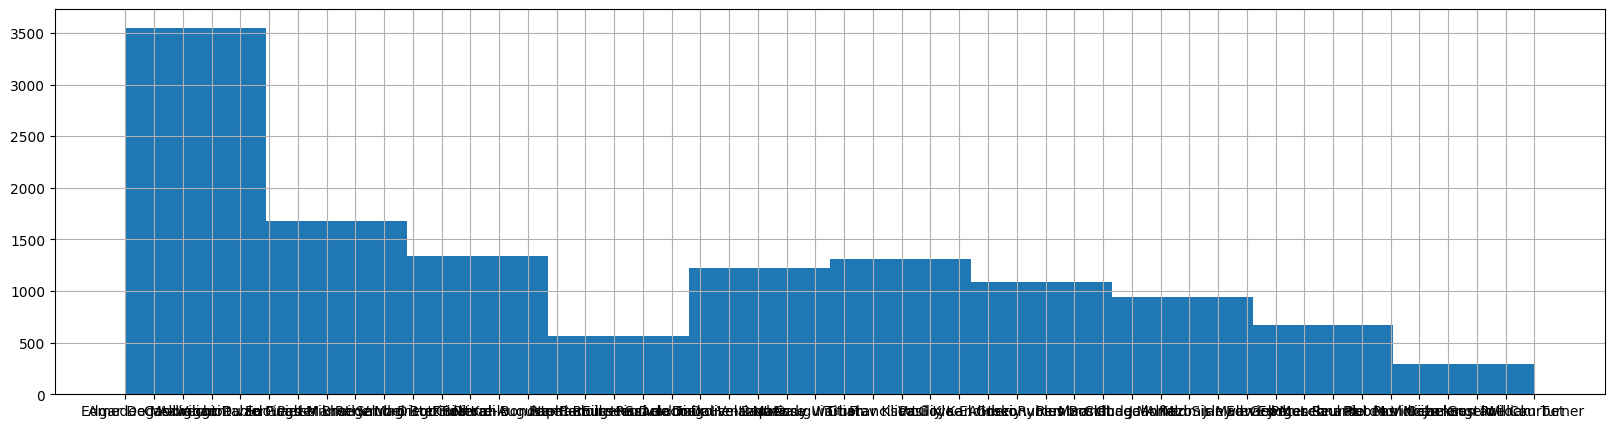

In [26]:
plt.figure(figsize=(20,5))
submisson['artist'].hist()

In [27]:
submisson['artist'].value_counts()

Vincent van Gogh             1452
Edgar Degas                  1092
Pablo Picasso                 750
Albrecht Du rer               560
Pierre-Auguste Renoir         524
Alfred Sisley                 493
Francisco Goya                432
Titian                        424
Paul Gauguin                  421
Rembrandt                     389
Amedeo Modigliani             359
Henri Matisse                 327
Marc Chagall                  295
Rene Magritte                 287
Peter Paul Rubens             251
Mikhail Vrubel                245
Giotto di Bondone             243
Sandro Botticelli             237
Pieter Bruegel                232
Andy Warhol                   229
Paul Klee                     195
Salvador Dali                 192
Frida Kahlo                   190
Raphael                       183
Diego Velazquez               175
Kazimir Malevich              175
Edouard Manet                 165
Gustav Klimt                  151
Leonardo da Vinci             148
El Greco      

In [28]:
len(submisson['artist'].value_counts())

50

In [29]:
submisson.to_csv(base_path+'/submit_EfficientNetB0_B3_4fold_raw_2_4_221108.csv', index=False)